# Modular version of rat tumors code

This is a modularized version of the rat tumor analysis, factored into reusable functions.

## Setup

Grab packages

In [1]:
library(ggplot2)
library(plyr)
library(tidyverse)
library(rstan)

Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summarise(): dplyr, plyr
summarize(): dplyr, plyr
Loading required package: StanHeaders
rstan (Version 2.16.2, packaged: 2017-07-03 09:24:58 UTC, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

Attaching package: ‘rstan’

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
library(doParallel)
registerDoParallel()

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: iterators
Loading required package: parallel


In [3]:
rstan_options(auto_write=TRUE)
options(mc.cores=parallel::detectCores())

Set options

In [4]:
options(repr.matrix.max.rows = 20)

Load the data:

In [5]:
rat.data = read_csv("rats.csv")
summary(rat.data)

Parsed with column specification:
cols(
  Infected = col_integer(),
  Total = col_integer()
)


    Infected          Total      
 Min.   : 0.000   Min.   :10.00  
 1st Qu.: 1.000   1st Qu.:19.00  
 Median : 3.000   Median :20.00  
 Mean   : 3.761   Mean   :24.49  
 3rd Qu.: 5.000   3rd Qu.:22.50  
 Max.   :16.000   Max.   :52.00  

In [6]:
rat.data

Infected,Total
0,20
0,20
0,20
0,20
0,20
0,20
0,20
0,19
0,19
0,19


## The Model

In this data set, for each experiment $j$, we have two observations: $c_j$, the number of infected rats, and $n_j$, the number of rats.

We model the data as having an infection rate $\theta_j$ for each experiment.  We want to make inferences about the distribution of $\theta_j$.

In more detail, we use the following model:

- $c_j \sim \mathrm{Bin}(n_j,\theta_j)$
- $\theta_j \sim \mathrm{Beta}(\alpha, \beta)$

For the purposes of notational simplicity theorem, we parameterize our model parameters as $\phi = (\alpha, \beta)$.

Therefore, we have the goal of computing $P(\phi,\mathbf{\theta}|\mathbf{c})$ given $\mathbf{c}$ and our model / likelihood function $P(\mathbf{c},\mathbf{\theta}|\phi) = \prod_j P(c_j,\theta_j|\phi_j) = \prod_j P(c_j|\theta_j)P(\theta_j|\phi_j)$.

The final derivation, as per Eq. 5.8 in Gelman et al., is 

$$P(\alpha, \beta|\mathrm{y}) \propto P(\alpha, \beta) \prod_j \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)} \frac{\Gamma(\alpha + c_j)\Gamma(\beta+n_j-c_j)}{\Gamma(\alpha+\beta+n_j)}$$

We will compute this log-transformed.

So we define the log likelihood function for this model. It will take as input $\alpha$ and $\beta$ vectors (which should be the same length), and return the log likelihood of each $(\alpha, \beta)$ value given the $\mathbf{c}$ and $\mathbf{n}$ vectors:

In [7]:
model.loglike = function(alpha, beta, cs, ns) {
    base = lgamma(alpha + beta) - lgamma(alpha) - lgamma(beta)
    data = mapply(a=alpha, b=beta, FUN=function(a, b) {
        sum(lgamma(a + cs) + 
                lgamma(b + ns - cs) - 
                lgamma(a + b + ns))
    })
    nrow(rat.data) * base + data
}

We're also going to use the diffuse prior from Equation 5.9:

$$P(\alpha, \beta) \propto (\alpha + \beta)^{-5/2}$$

We will not worry about the constant, since we care about *relative* densities.

In [8]:
model.prior = prior = function(alpha, beta) {
    (alpha + beta) ^ (-5 / 2)
}

## Densities in Transformed Space

We want to be able to compute and reason about the probability density at various $\alpha$ and $\beta$ values. However, raw $\alpha \times \beta$ space is not very convenient, so we will plot instead over $x = \mathrm{log}(\frac{\alpha}{\beta})$ and $y = \mathrm{log}(\alpha + \beta)$, yielding:

$$\begin{align*}
x & = \mathrm{log}(\frac{\alpha}{\beta}) \\
y & = \mathrm{log}(\alpha + \beta) \\
\alpha & = e^x \beta \\
\beta & = \frac{e^y}{e^x + 1}
\end{align*}$$

In [9]:
par.beta = function(x, y) {
    exp(y) / (exp(x) + 1)
}
par.alpha = function(x, y) {
    exp(x) * par.beta(x, y)
}

Given ranges (really, sequences) of $x$ and $y$ values, we want to compute the probability density.  We call this `xydensity` because it is the density at $(x, y)$.  It returns the density at each pair $(x, y)$, taking the Cartesian product of the `x` and `y` vectors. The `counts` and `totals` parameters ($\mathbf{c}$ and $\mathbf{n}$) are also vectors, but the value for each $(x,y)$ poitn depends on the entire $\mathbf{c}$ and $\mathbf{n}$ vectors.

In [10]:
xydensity = function(x, y, counts, totals, prior=model.prior, loglike=model.loglike) {
    expand.grid(x=x, y=y) %>%
        mutate(alpha = par.alpha(x, y),
               beta = par.beta(x, y)) %>%
        mutate(logPrior = log(prior(alpha, beta)),
               logLike = loglike(alpha, beta, counts, totals),
               rawLogPost = logPrior + logLike) %>%
        mutate(logJacobian = log(alpha) + log(beta),
               logPost = rawLogPost + logJacobian)
}

Let's now try it:

In [11]:
dens.points = xydensity(x=sample(seq(-2.3, -1.3, 0.005), 100),
                        y=sample(seq(1, 5, 0.005), 100),
                        counts=rat.data$Infected, totals=rat.data$Total)
dens.points

x,y,alpha,beta,logPrior,logLike,rawLogPost,logJacobian,logPost
-2.200,4.79,12.00012,108.30125,-11.975,-754.1022,-766.0772,7.169833,-758.9073
-1.485,4.79,22.21646,98.08491,-11.975,-745.7459,-757.7209,7.686667,-750.0342
-2.195,4.79,12.05424,108.24712,-11.975,-753.7877,-765.7627,7.173834,-758.5889
-1.505,4.79,21.85647,98.44490,-11.975,-744.7450,-756.7200,7.673994,-749.0461
-1.795,4.79,17.13823,103.16314,-11.975,-739.1231,-751.0981,7.477623,-743.6205
-1.825,4.79,16.70204,103.59933,-11.975,-739.4081,-751.3831,7.456062,-743.9270
-1.610,4.79,20.04084,100.26053,-11.975,-740.8506,-752.8256,7.605544,-745.2201
-1.515,4.79,21.67818,98.62319,-11.975,-744.2764,-756.2514,7.667613,-748.5838
-1.500,4.79,21.94604,98.35533,-11.975,-744.9873,-756.9623,7.677173,-749.2851
-1.830,4.79,16.63025,103.67112,-11.975,-739.4700,-751.4450,7.452447,-743.9925


In [12]:
dim(dens.points)

[1] 10000     9

In [13]:
summary(dens.points %>% select(rawLogPost, logLike, logPost))

   rawLogPost        logLike          logPost      
 Min.   :-775.6   Min.   :-763.1   Min.   :-768.1  
 1st Qu.:-751.9   1st Qu.:-744.0   1st Qu.:-747.5  
 Median :-746.0   Median :-739.0   Median :-742.7  
 Mean   :-747.5   Mean   :-740.1   Mean   :-743.7  
 3rd Qu.:-741.6   3rd Qu.:-734.6   3rd Qu.:-738.2  
 Max.   :-737.0   Max.   :-730.3   Max.   :-733.8  

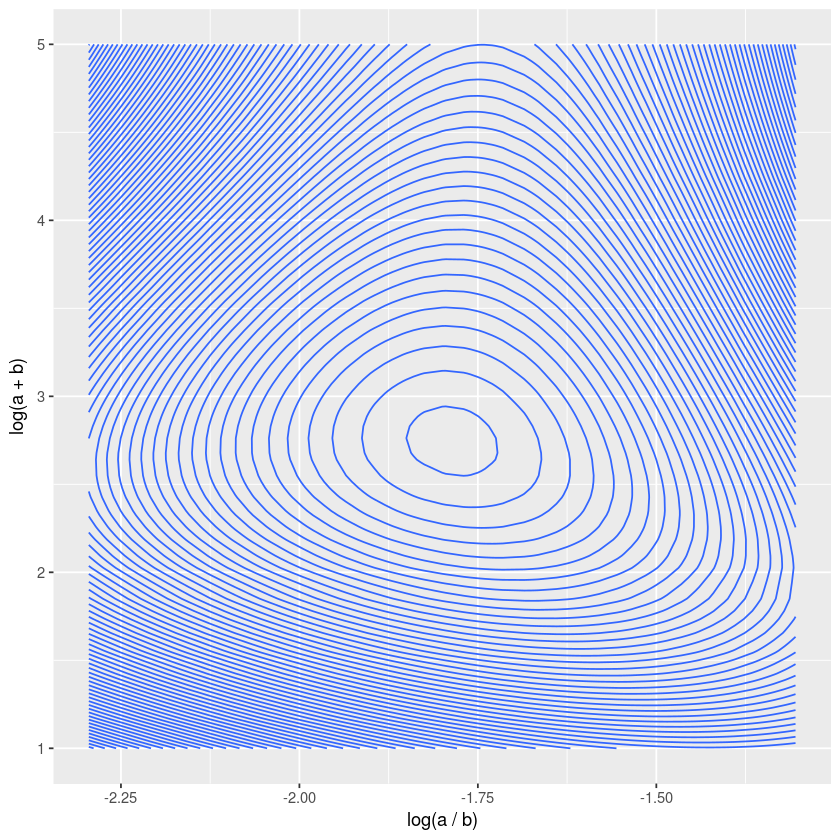

In [14]:
ggplot(dens.points) +
    aes(x=x, y=y, z=logPost) +
    geom_contour(binwidth=0.5) +
    xlab("log(a / b)") +
    ylab("log(a + b)")

## Inference for Parameter Values

With the model in place, we want to use the computed point densities to do some esimation of the posterior distributions.

In [15]:
expvals = function(dens) {
    normPost = dens$logPost - max(dens$logPost)
    alpha = sum(dens$alpha * exp(normPost)) / sum(exp(normPost))
    beta = sum(dens$beta * exp(normPost)) / sum(exp(normPost))
    x = log(alpha / beta)
    y = log(alpha + beta)
    mean = alpha / (alpha + beta)
    data.frame(alpha=alpha, beta=beta, x=x, y=y, mean=mean)
}

In [16]:
expvals(dens.points)

alpha,beta,x,y,mean
2.386292,14.15951,-1.780646,2.806132,0.1442234


## MAP estimate

We want to find the *maximum* value of the log posterior, so that we can use it later for normalization in the integral.  The `optim` function seems perfect for this!

In [17]:
model.map = optim(c(1, 1), function(pars) {
    alpha = pars[1]
    beta = pars[2]
    log(model.prior(alpha, beta)) + model.loglike(alpha, beta, rat.data$Infected, rat.data$Total)
}, control=list(fnscale=-1))
model.map

$par
[1]  1.82629 10.84766

$value
[1] -737.0054

$counts
function gradient 
      71       NA 

$convergence
[1] 0

$message
NULL


## Integral Inference for the Posterior

First, we will write a function to compute the probability density of a particular $\theta$, as an integral $P(\theta|\mathbf{y}) = \iint P(\theta|\alpha,\beta)P(\alpha,\beta|\mathbf{y}) \, \mathrm{d}\alpha \mathrm{d}\beta$.

This function is over `theta` (it will return a vector of densities, one corresponding to each value of `theta`).  The `norm` parameter is a normalizing constant used to make the log likelihoods exponentiable within the limits of floating point accuracy; a value a little less than the maximum log likelihood computed by the `xydensity` function is a good choice.

In [18]:
model.theta.post = function(theta, logScale, counts, totals, prior=model.prior, loglike=model.loglike,
                            parallel=!identical(Sys.info()[["sysname"]], "Windows")) {
    aaply(theta, 1, function(thv) {
        integrate(function(beta) {
            aaply(beta, 1, function(bv) {
                integrate(function(alpha) {
                    ll = loglike(alpha, bv, counts, totals)
                    like = exp(ll - logScale)
                    pth = dbeta(thv, alpha, bv)
                    pth * prior(alpha, bv) * like
                }, 0, Inf, rel.tol = 0.001)$value
                })
            }, 0, Inf, rel.tol = 0.001)$value
    }, .parallel=parallel)
}

What's our maximum density? We'll use that as a starting point for scaling.

In [19]:
model.map$value

[1] -737.0054

Let's compute; we do a second normalization to account for the fact that we are computing on intervals of 0.001, to try to make the area under the curve sum to 1.  This computation takes a little while.

In [20]:
theta.post = data.frame(Theta=seq(0.01, 0.99, 0.005)) %>%
    mutate(RawPostDens = model.theta.post(Theta, model.map$value + 1,
                                          rat.data$Infected, rat.data$Total)) %>%
    mutate(PostDens = RawPostDens / sum(RawPostDens * 0.005))

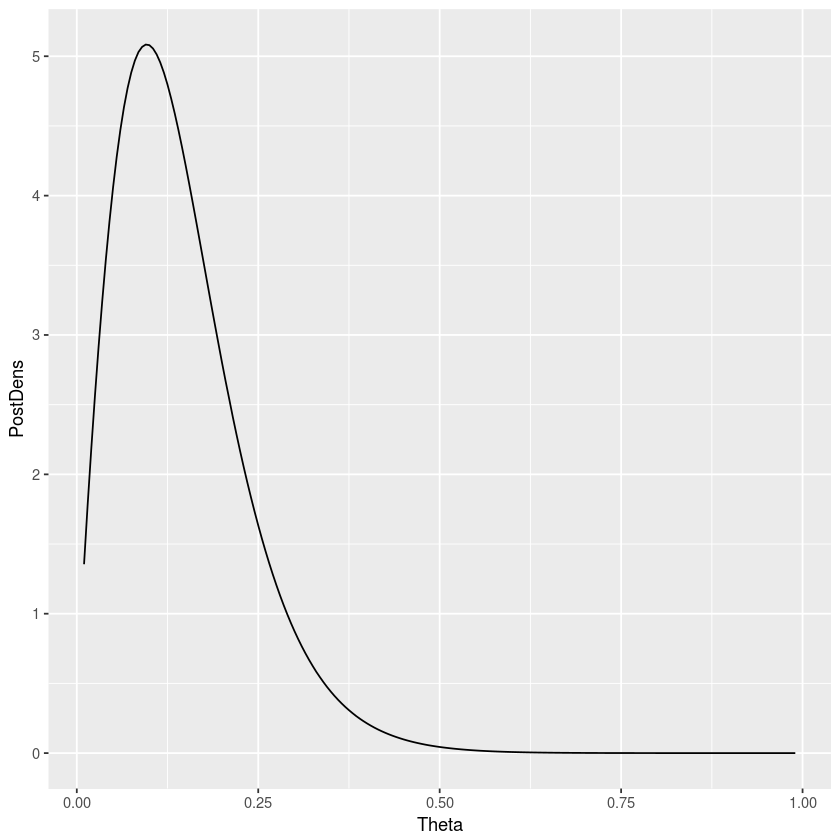

In [21]:
ggplot(theta.post) +
    aes(x=Theta, y=PostDens) +
geom_line()

## Monte Carlo Simulation of the Posterior

Now we are going to use STAN to conduct an MCMC simulation of the posterior distribution.

In [23]:
writeLines(readLines("ratmodel.stan"))

data {
    int<lower=0> J;
    int<lower=0> n[J];
    int<lower=0> y[J];
}
parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    real<lower=0,upper=1> theta[J];
}
model {
    theta ~ beta(alpha, beta);
    y ~ binomial(n, theta);
}


In [24]:
rat_fit = stan(file="ratmodel.stan", data=list(J=nrow(rat.data), y=rat.data$Infected, n=rat.data$Total),
               iter=1000, chains=4, control=list(adapt_delta=0.99))

hash mismatch so recompiling; make sure Stan code ends with a blank line


In file included from /home/MICHAELEKSTRAND/miniconda2/envs/rats/lib/R/library/rstan/include/rstan/rstaninc.hpp:3:0,
                 from file13e2b6020c641.cpp:440:
/home/MICHAELEKSTRAND/miniconda2/envs/rats/lib/R/library/rstan/include/rstan/stan_fit.hpp: In function 'int rstan::{anonymous}::command(rstan::stan_args&, Model&, Rcpp::List&, const std::vector<long unsigned int>&, const std::vector<std::__cxx11::basic_string<char> >&, RNG_t&)':
/home/MICHAELEKSTRAND/miniconda2/envs/rats/lib/R/library/rstan/include/rstan/stan_fit.hpp:438:8: warning: 'template<class> class std::auto_ptr' is deprecated [-Wdeprecated-declarations]
   std::auto_ptr<stan::io::var_context> init_context_ptr;
        ^~~~~~~~
In file included from /home/MICHAELEKSTRAND/miniconda2/envs/rats/x86_64-conda_cos6-linux-gnu/include/c++/7.2.0/bits/locale_conv.h:41:0,
                 from /home/MICHAELEKSTRAND/miniconda2/envs/rats/x86_64-conda_cos6-linux-gnu/include/c++/7.2.0/locale:43,
                 from /home/MICHAEL

In [25]:
print(rat_fit)

Inference for Stan model: ratmodel.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean    sd    2.5%     25%     50%     75%   97.5% n_eff
alpha        3.49    0.14  1.68    1.57    2.36    3.07    4.10    7.48   140
beta        20.86    0.86 10.11    9.34   14.30   18.70   24.29   45.64   138
theta[1]     0.07    0.00  0.04    0.01    0.04    0.07    0.10    0.17  2000
theta[2]     0.08    0.00  0.04    0.01    0.05    0.07    0.10    0.17  2000
theta[3]     0.07    0.00  0.04    0.01    0.04    0.07    0.10    0.17  2000
theta[4]     0.07    0.00  0.04    0.01    0.04    0.07    0.10    0.17  2000
theta[5]     0.08    0.00  0.04    0.01    0.04    0.07    0.10    0.17  2000
theta[6]     0.08    0.00  0.04    0.01    0.04    0.07    0.10    0.17  2000
theta[7]     0.08    0.00  0.04    0.01    0.04    0.07    0.10    0.17  2000
theta[8]     0.08    0.00  0.04    0.01    0.04    0.07    0.10    0

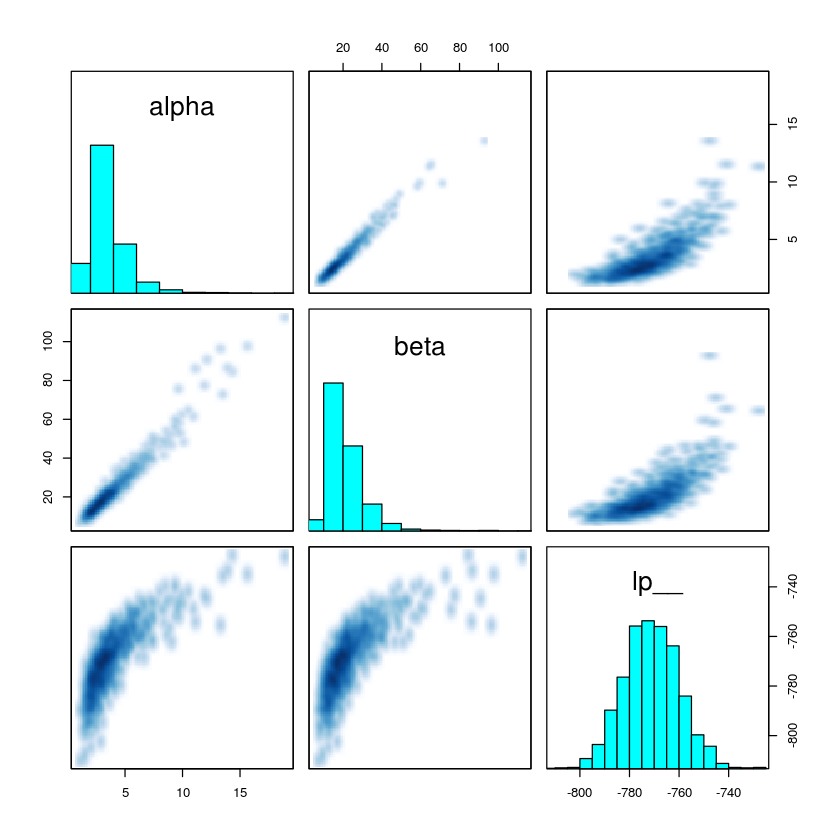

In [26]:
pairs(rat_fit, pars=c("alpha", "beta", "lp__"))

In [27]:
rat_sim = rstan::extract(rat_fit, permuted=TRUE)

In [28]:
n_sims = length(rat_sim$lp__)
n_sims

[1] 2000

In [29]:
theta_sims = data_frame(alpha=rat_sim$alpha, beta=rat_sim$beta) %>%
    mutate(Theta=rbeta(n(), alpha, beta))

In [30]:
summary(theta_sims)

     alpha             beta             Theta         
 Min.   : 1.041   Min.   :  6.696   Min.   :0.003298  
 1st Qu.: 2.364   1st Qu.: 14.301   1st Qu.:0.086690  
 Median : 3.071   Median : 18.696   Median :0.129438  
 Mean   : 3.487   Mean   : 20.864   Mean   :0.141307  
 3rd Qu.: 4.105   3rd Qu.: 24.285   3rd Qu.:0.183722  
 Max.   :18.909   Max.   :112.569   Max.   :0.495186  

In [31]:
theta_dens = density(theta_sims$Theta)

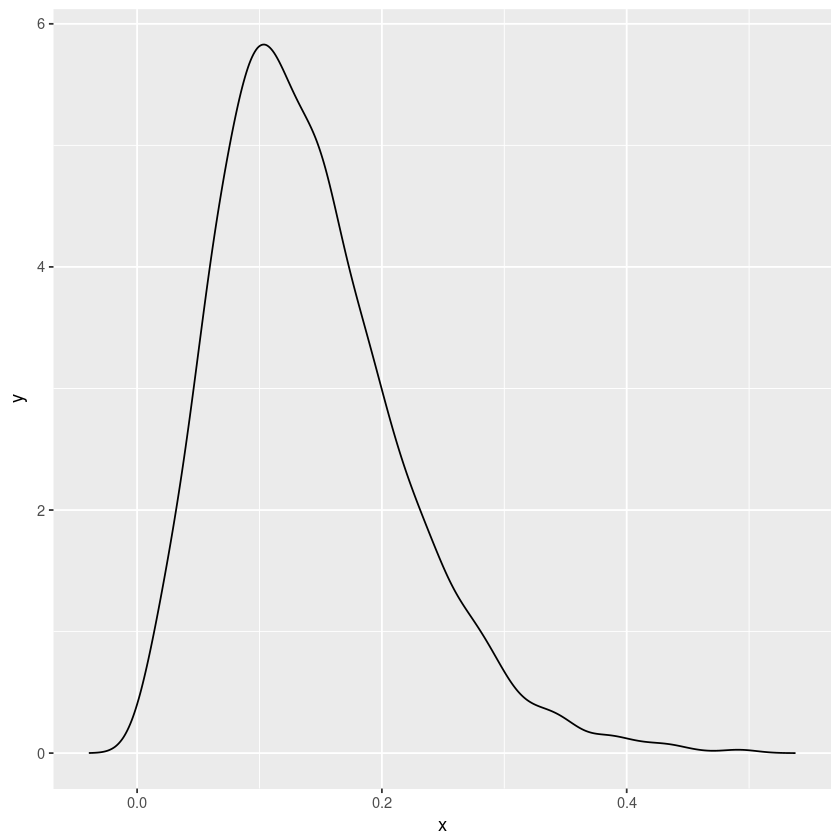

In [32]:
ggplot(data_frame(x=theta_dens$x, y=theta_dens$y)) +
    aes(x, y) +
    geom_line()

### Use priors & reparameterization

In [33]:
writeLines(readLines("ratxmodel.stan"))

data {
    int<lower=0> J;
    int<lower=0> n[J];
    int<lower=0> y[J];
}
parameters {
    real<lower=0,upper=1> phi;
    real<lower=0.1> lambda;
    real<lower=0,upper=1> theta[J];
}
transformed parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    alpha = lambda * phi;
    beta = lambda * 1 - phi;
}
model {
    phi ~ beta(1,1);
    lambda ~ pareto(0.1, 1.5);
    theta ~ beta(alpha, beta);
    y ~ binomial(n, theta);
}


In [34]:
ratx_fit = stan(file="ratxmodel.stan",
                data=list(J=nrow(rat.data), y=rat.data$Infected, n=rat.data$Total),
                iter=1000, chains=4, control=list(adapt_delta=0.99))

In [35]:
print(ratx_fit)

Inference for Stan model: ratxmodel.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
phi          0.17    0.00 0.02    0.13    0.16    0.17    0.18    0.21  1244
lambda      12.43    0.23 4.31    6.26    9.42   11.71   14.56   22.93   352
theta[1]     0.06    0.00 0.04    0.00    0.03    0.05    0.08    0.17  2000
theta[2]     0.06    0.00 0.04    0.00    0.03    0.05    0.08    0.15  2000
theta[3]     0.06    0.00 0.04    0.00    0.03    0.05    0.08    0.16  2000
theta[4]     0.06    0.00 0.04    0.00    0.03    0.05    0.08    0.17  2000
theta[5]     0.06    0.00 0.04    0.01    0.03    0.05    0.08    0.16  2000
theta[6]     0.06    0.00 0.04    0.01    0.03    0.05    0.08    0.16  2000
theta[7]     0.06    0.00 0.04    0.00    0.03    0.05    0.08    0.16  2000
theta[8]     0.06    0.00 0.04    0.01    0.03    0.05    0.09    0.17  2000


In [36]:
ratx_sim = rstan::extract(ratx_fit, permuted=TRUE)

In [37]:
n_sims = length(ratx_sim$lp__)
n_sims

[1] 2000

In [38]:
thetax_sims = data_frame(alpha=ratx_sim$alpha, beta=ratx_sim$beta) %>%
    mutate(Theta=rbeta(n(), alpha, beta))

In [39]:
summary(thetax_sims)

     alpha             beta            Theta          
 Min.   :0.7255   Min.   : 3.949   Min.   :0.0003899  
 1st Qu.:1.5695   1st Qu.: 9.248   1st Qu.:0.0740209  
 Median :1.9482   Median :11.553   Median :0.1294079  
 Mean   :2.0797   Mean   :12.265   Mean   :0.1465249  
 3rd Qu.:2.4497   3rd Qu.:14.395   3rd Qu.:0.1996516  
 Max.   :6.8578   Max.   :35.257   Max.   :0.5698463  

In [40]:
thetax_dens = density(thetax_sims$Theta)

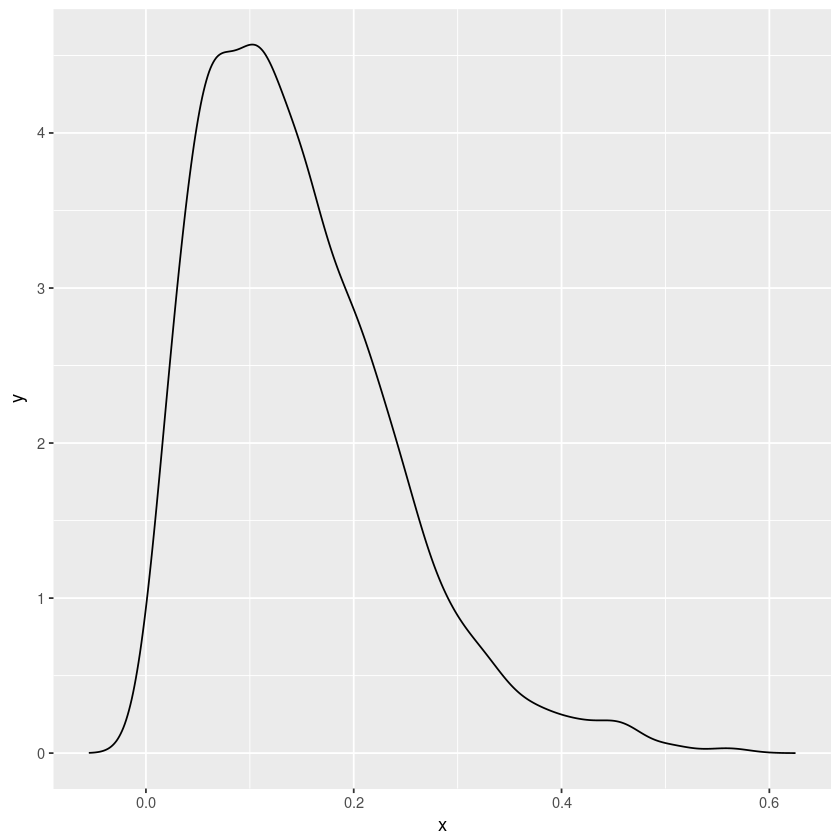

In [41]:
ggplot(data_frame(x=thetax_dens$x, y=thetax_dens$y)) +
    aes(x, y) +
    geom_line()

## Unified Plots

In [42]:
posteriors = bind_rows(Integrated=select(theta.post, Theta, Density=PostDens),
                       MCMC=data_frame(Theta=theta_dens$x, Density=theta_dens$y),
                       MCMC_RP=data_frame(Theta=thetax_dens$x, Density=thetax_dens$y),
                       .id="Method")

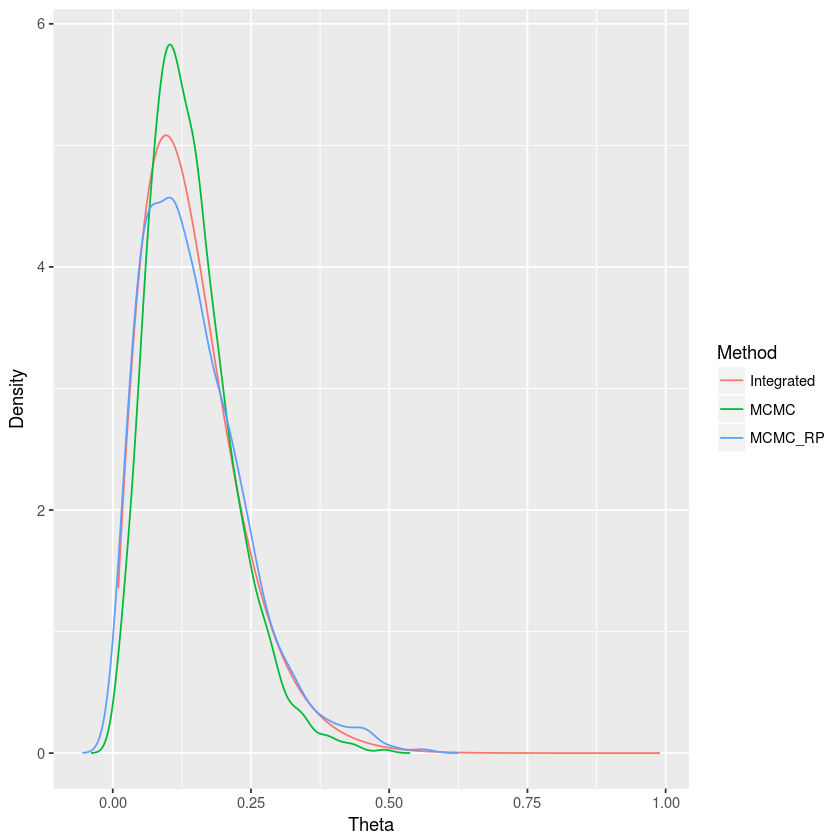

In [43]:
ggplot(posteriors) +
    aes(x=Theta, y=Density, color=Method) +
    geom_line()